

# Data Scientist Professional Case Study

### Company Background

Tasty Bytes , an online recipe startup, has hired you as a data scientist. The website features new recipes on the homepage every day. The owner has told you that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular.

Recipes are considered to be popular if they receive a high score. The data team has collected data from previously published recipes.



### Customer Question

The owner wants to know:
- Can you use information on previously published recipes to predict whether a recipe will receive a high score?




### Success Criteria

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how your approach compares to this.


### Dataset

The data you will use for this analysis can be accessed here: `"data/recipes.csv"`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

First we read the csv in order to create a Dataframe to work with and we inspect the first 10 rows

In [2]:
#Read csv
df = pd.read_csv('data/recipes.csv')

#Print first 10 rows
print(df.head(10))

   RecipeId                                        Name RecipeCategory  \
0     46085                 Crock Pot Baked Potato Soup  One Dish Meal   
1     93832  Frittata Di Spaghetti (spaghetti Frittata)      Breakfast   
2     36034                  Berries With Italian Cream        Dessert   
3    329988  Pork Tenderloin Medallions With Fresh Figs      < 15 Mins   
4     59886   Kaseropita (Tiropita Using Kaseri Cheese)    Savory Pies   
5    328806                  My Kids Breakfast Smoothie      Smoothies   
6    375975          Moroccan Meatballs in Tomato Sauce     Lamb/Sheep   
7    189787       Eggplant (Aubergine) and Tomato Crisp      Vegetable   
8    424798                         Very Berry Iced Tea      Beverages   
9     17549                           Burnished Bananas        Dessert   

   Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
0     699.8               137.3                 46.1           1.4   
1     297.1               191.8              

## Data Validation

Next step is validate the data, we will check the actual data type of each column, change it to correct values if necessary. Also we will check for missing values, duplicated values and outliers in order to clean our data for the model

Now we inspect our data, types of data, number of non-null and total number of rows and columns

In [3]:
#Print data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecipeId             43092 non-null  int64  
 1   Name                 43092 non-null  object 
 2   RecipeCategory       43052 non-null  object 
 3   Calories             43092 non-null  float64
 4   CholesterolContent   43092 non-null  float64
 5   CarbohydrateContent  43092 non-null  float64
 6   SugarContent         43092 non-null  float64
 7   ProteinContent       43092 non-null  float64
 8   RecipeServings       43092 non-null  float64
 9   HighScore            43092 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 3.3+ MB
None


As we can see, there are 43092 rows and 10 columns, there are some missing values in the column Recipe Category, we will first drop the missing values, and check whether there are duplicates

In [4]:
#Number of missing values
print(df.isna().sum())

#Drop missing values
df.dropna(inplace=True)

#Number of missing values
print(df.isna().sum())

RecipeId                0
Name                    0
RecipeCategory         40
Calories                0
CholesterolContent      0
CarbohydrateContent     0
SugarContent            0
ProteinContent          0
RecipeServings          0
HighScore               0
dtype: int64
RecipeId               0
Name                   0
RecipeCategory         0
Calories               0
CholesterolContent     0
CarbohydrateContent    0
SugarContent           0
ProteinContent         0
RecipeServings         0
HighScore              0
dtype: int64


In [5]:
#Number of duplcates 
print(df.duplicated().sum())

0


Now we will convert RecipeCategory to category type data, and HighScore to boolean

In [6]:
#Transform RecipeCategory to category type
df['RecipeCategory'] = df['RecipeCategory'].astype('category')

#Transform HighScore to bolean
df['HighScore'] = df['HighScore'].astype('bool')

#Check the results
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43052 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RecipeId             43052 non-null  int64   
 1   Name                 43052 non-null  object  
 2   RecipeCategory       43052 non-null  category
 3   Calories             43052 non-null  float64 
 4   CholesterolContent   43052 non-null  float64 
 5   CarbohydrateContent  43052 non-null  float64 
 6   SugarContent         43052 non-null  float64 
 7   ProteinContent       43052 non-null  float64 
 8   RecipeServings       43052 non-null  float64 
 9   HighScore            43052 non-null  bool    
dtypes: bool(1), category(1), float64(6), int64(1), object(1)
memory usage: 3.1+ MB
None


In the next step we will take a look to the summary statistics in order to look for outliers in our numeric columns and get a first look of the numeric distribution of our data

In [7]:
 #Check summary statistics
print(df.describe())

            RecipeId      Calories  CholesterolContent  CarbohydrateContent  \
count   43052.000000  43052.000000        43052.000000         43052.000000   
mean   224646.245842    353.260578           69.467690            32.841280   
std    141984.419635    405.203249          112.457435            46.440408   
min        38.000000      0.000000            0.000000             0.000000   
25%    102521.750000    164.800000            4.500000            11.600000   
50%    212251.500000    284.100000           40.700000            25.400000   
75%    336700.250000    446.700000           95.800000            43.400000   
max    540876.000000  30933.400000         9167.200000          3564.400000   

       SugarContent  ProteinContent  RecipeServings  
count  43052.000000    43052.000000    43052.000000  
mean      12.210450       15.765203        9.520812  
std       28.315172       21.592068      224.126883  
min        0.000000        0.000000        1.000000  
25%        2.20000

As we can see by comparing the 75th percentile with max values, there might be large outliers in our data, we don't take into account RecipeID column.

HighScore values are ok, as we have a max value of 1 and min of 0.

Lets create a box plot for each of the numeric columns of interest. 

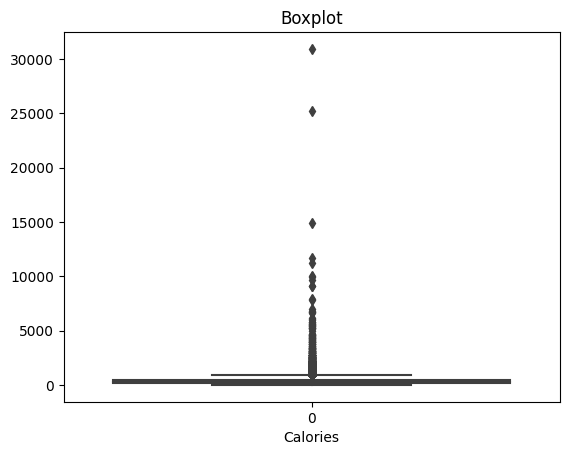

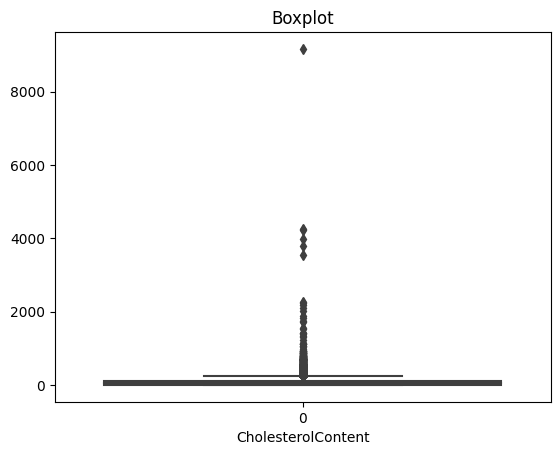

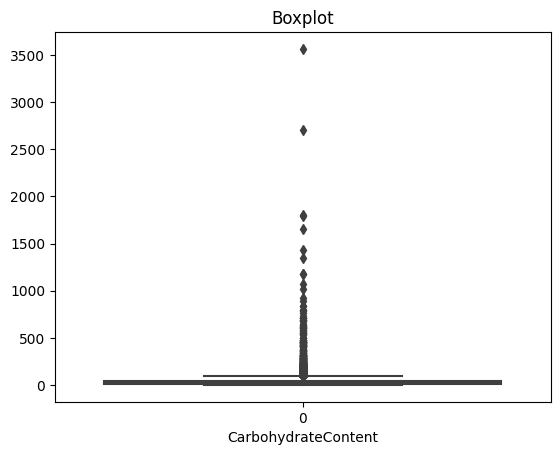

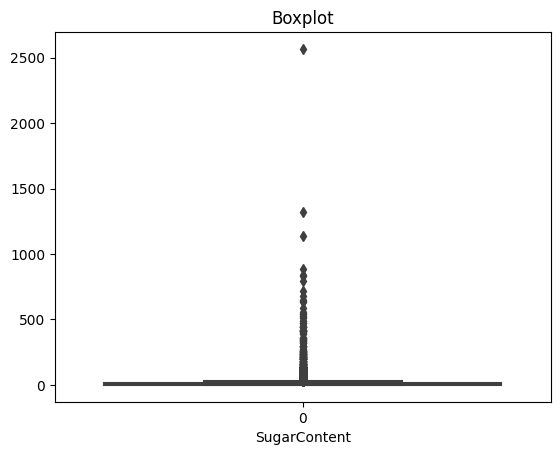

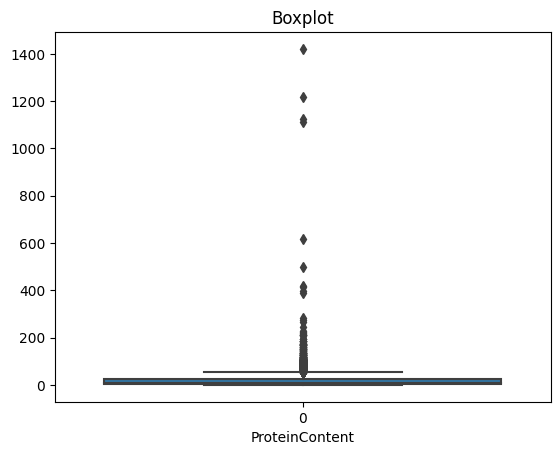

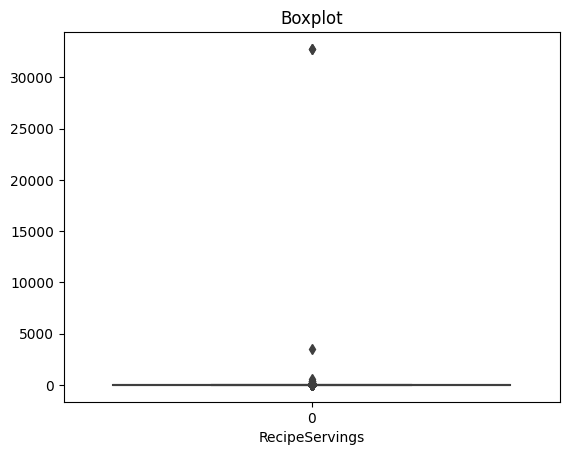

In [8]:
#Numeric columns of the dataframe
numeric_cols = ['Calories','CholesterolContent','CarbohydrateContent', 'SugarContent', 'ProteinContent','RecipeServings']

#boxplots
for i in numeric_cols:    
    sns.boxplot(data = df[i])
    plt.title('Boxplot')
    plt.xlabel(i)
    plt.show()

As we can see in the charts the large number of outliers makes difficult to see the distribution of the data, we will create a function in order to spot the outliers, quantify them and later be able to drop it

In [9]:
def outliers(df, col):
    """Function that returns the number of outliers, the %, and the points of a pandas series
    
    Arg(series): Pandas Series
    Arg(col): string
    returns: two lists:  index of outliers / number of outliers and percentage    
    """
    
    #Create list for number of outliers, percentage of outliers
    outliers_data = []
    
    #Calculate 25th percentile
    q1 = np.percentile(df[col],25)
    
    #Calculate 75th percentile
    q3 = np.percentile(df[col], 75)
    
    #Calculate IQR
    iqr = q3 - q1
    
    #Calculate outlier point
    outlier_point = iqr * 1.5
    
    #Get index of outliers rows
    outliers_idx = df[(df[col] > q3 + outlier_point) | (df[col] < q1 - outlier_point)].index
    
    #Get number of outliers
    n_outliers = len(df[(df[col] > q3 + outlier_point) | (df[col] < q1 - outlier_point)])
    
    #Percentage of outliers
    p_outliers = round(n_outliers / len(df), 2)
    
    #Append number of outliers
    outliers_data.append(n_outliers)
    
    #Append percentage of outliers
    outliers_data.append(p_outliers)
    
    return outliers_idx, outliers_data

In [10]:
#Numeric columns of the dataframe
numeric_cols = ['Calories','CholesterolContent','CarbohydrateContent', 'SugarContent', 'ProteinContent','RecipeServings']

#Iterate over columns print outliers information
for i in numeric_cols:
    out_idx, out_np = outliers(df,i)
    print('{}: {} outliers, {}% of total'.format(i, out_np[0], out_np[1]*100))

Calories: 1838 outliers, 4.0% of total
CholesterolContent: 2098 outliers, 5.0% of total
CarbohydrateContent: 1568 outliers, 4.0% of total
SugarContent: 3893 outliers, 9.0% of total
ProteinContent: 1203 outliers, 3.0% of total
RecipeServings: 4522 outliers, 11.0% of total


In [11]:
#Drop outliers columns
for i in numeric_cols:
    out_idx, out_np = outliers(df,i)
    df.drop(out_idx, inplace = True)
    
#Print the result
print(len(df))

30808


In [12]:
#Inspect the resulting data frame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30808 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RecipeId             30808 non-null  int64   
 1   Name                 30808 non-null  object  
 2   RecipeCategory       30808 non-null  category
 3   Calories             30808 non-null  float64 
 4   CholesterolContent   30808 non-null  float64 
 5   CarbohydrateContent  30808 non-null  float64 
 6   SugarContent         30808 non-null  float64 
 7   ProteinContent       30808 non-null  float64 
 8   RecipeServings       30808 non-null  float64 
 9   HighScore            30808 non-null  bool    
dtypes: bool(1), category(1), float64(6), int64(1), object(1)
memory usage: 2.2+ MB
None


In [13]:
#Inspect the summary statistics of numeric columns again
print(df.describe())

            RecipeId      Calories  CholesterolContent  CarbohydrateContent  \
count   30808.000000  30808.000000        30808.000000         30808.000000   
mean   225861.191898    288.640869           52.477645            25.594453   
std    142342.402838    171.072411           53.354917            18.533665   
min        38.000000      0.000000            0.000000             0.000000   
25%    102411.500000    159.375000            2.100000            10.500000   
50%    214902.000000    263.600000           38.200000            22.500000   
75%    338112.000000    391.625000           85.000000            37.000000   
max    540587.000000    869.500000          218.500000            87.300000   

       SugarContent  ProteinContent  RecipeServings  
count  30808.000000    30808.000000    30808.000000  
mean       6.980473       14.339821        5.710789  
std        7.052555       12.705771        2.915307  
min        0.000000        0.000000        1.000000  
25%        1.90000

We can spot also that the minimum of the Calories and other columns is 0 lets have a look to those

In [14]:
#Print columns where Calories is = 0
print(df[df['Calories'] == 0])

       RecipeId                                               Name  \
283      103014  Espresso Without a Machine Using a Single Serv...   
711      251628                   Serviette/Napkin, from the Heart   
878       66525                            Raisinet Banana Muffins   
905      291893                                          Irish Ice   
961      375040  Sweet Tea Vodka Cocktail (Aka: My Perfect Summ...   
...         ...                                                ...   
41515    256567                         Popcorn (Paper Bag Method)   
42118    197949                                   Ciclon Margarita   
42146    279076                           Drought Breaker Mocktail   
42365     67104                            Carol's EASY FISH TACOS   
42962    263420            The Perfect Pot and Cup of English Tea!   

        RecipeCategory  Calories  CholesterolContent  CarbohydrateContent  \
283          Smoothies       0.0                 0.0                  0.0   
711  

It seems that there might be recipes with 0 in all calories and content columns. We will drop those ones as well

In [15]:
#Create temporary column col_sum as the horizontal sum of calories and content cols
df['col_sum'] = df[['Calories','CholesterolContent','CarbohydrateContent', 'SugarContent', 'ProteinContent']].sum(axis=1)

#Filter by col_sum = 0
mask = df['col_sum'] == 0

#Get index
idx_0 = df[mask].index

#Print total number
print(len(idx_0))
                   
#Drop rows
df.drop(idx_0, inplace = True)

#Drop temporary column
df.drop(['col_sum'], axis = 1, inplace = True)

172


In [16]:
#Print again DF
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30636 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RecipeId             30636 non-null  int64   
 1   Name                 30636 non-null  object  
 2   RecipeCategory       30636 non-null  category
 3   Calories             30636 non-null  float64 
 4   CholesterolContent   30636 non-null  float64 
 5   CarbohydrateContent  30636 non-null  float64 
 6   SugarContent         30636 non-null  float64 
 7   ProteinContent       30636 non-null  float64 
 8   RecipeServings       30636 non-null  float64 
 9   HighScore            30636 non-null  bool    
dtypes: bool(1), category(1), float64(6), int64(1), object(1)
memory usage: 2.2+ MB
None


### Data Validation Summary

After inspecting the data we have perform the following cleaning tasks:
- Drop Missing Values
- Check the presence of duplicated values
- Change Recipe Category column to categorical data type
- Change High Score column to boolean data type
- Drop the outliers for Calories, Cholesterol Content, Carbohydrate Content, Sugar Content and Protein Content columns
- Drop columns with all values of Calories and Content columns equal to 0

Our Data Frame now has 30636 rows, with no missing values or duplicates and all the correct data types

## Exploratory Analysis
Now that we have cleaned our data lets continue with the Exploratory Analysis process, first we will create again the boxplot charts for our numeric variables after dropping the initial outliers

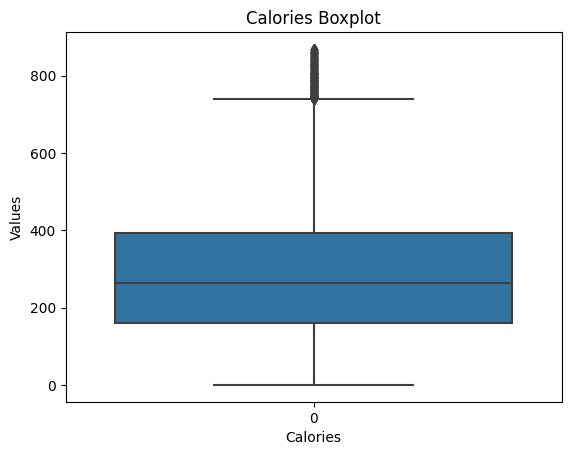

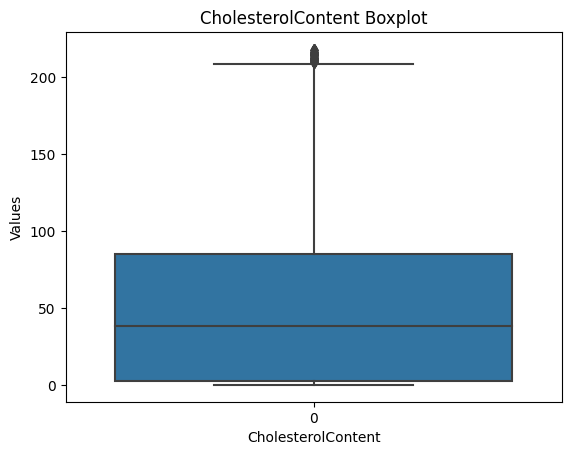

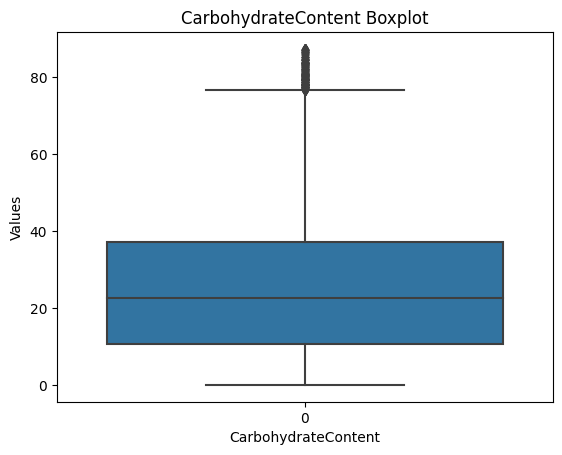

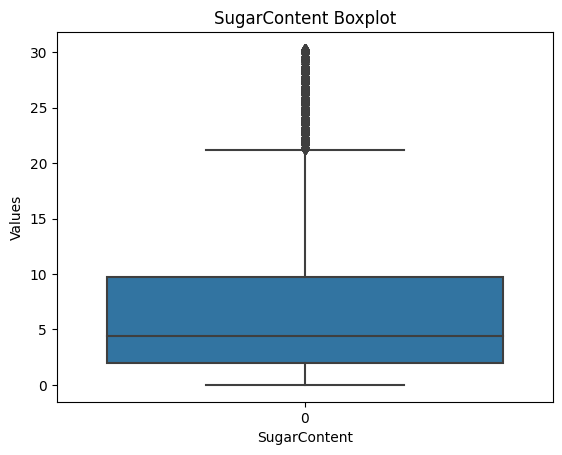

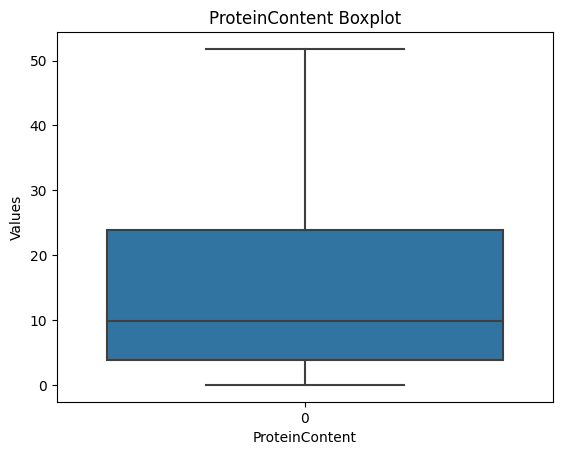

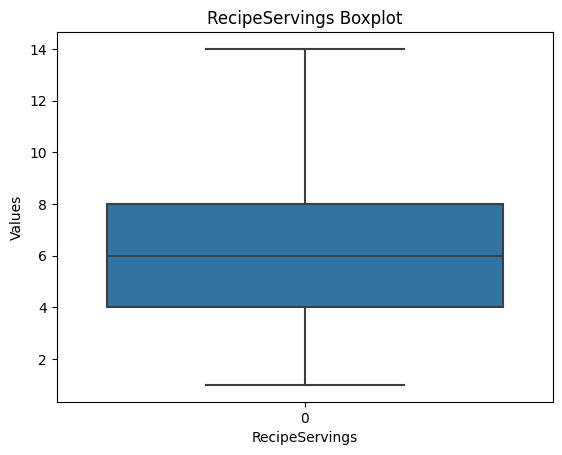

In [17]:
#Numeric columns of the dataframe
numeric_cols = ['Calories','CholesterolContent','CarbohydrateContent', 'SugarContent', 'ProteinContent','RecipeServings']

#Create boxplot for each column
for i in numeric_cols:
    sns.boxplot(data = df[i])
    plt.title(i + " " + 'Boxplot')
    plt.xlabel(i)
    plt.ylabel('Values')
    plt.show()

As we can see now the distribution of our variables make more sense, lets continue analyzing our categorical variable Recipe Category,

In [18]:
#Print unique categories
print(len(df['RecipeCategory'].unique()))

240


In [19]:
#Recipes per category, percentage of total
category_n = df['RecipeCategory'].value_counts(normalize=True)

#Filter for the ones with a value count higher than 1% 
top_category_n = category_n[category_n > 0.01]

#Print 
print(top_category_n)

#Print the number and the sum of those
print(len(top_category_n), top_category_n.sum())

Lunch/Snacks      0.086728
One Dish Meal     0.077654
Vegetable         0.075336
Dessert           0.048636
Beverages         0.046220
Chicken Breast    0.038321
Breakfast         0.036787
Chicken           0.035579
Potato            0.032674
Meat              0.029638
Pork              0.028757
Cheese            0.020205
Breads            0.018181
Quick Breads      0.017920
< 60 Mins         0.015635
Sauces            0.014852
< 30 Mins         0.014689
Stew              0.012730
Beans             0.012306
< 15 Mins         0.010870
Name: RecipeCategory, dtype: float64
20 0.6737171954563259


The top 20 Recipes account for the 67.37 % of the total, having in total 240 unique Recipe categories

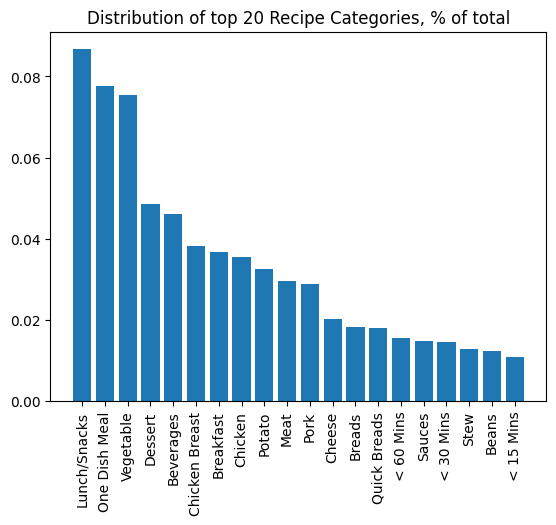

In [20]:
#Get Categories names:
names = top_category_n.index.tolist()

#Plot distribution of categories
plt.bar(x= names, height = top_category_n.values)
plt.xticks(rotation='vertical')
plt.title('Distribution of top 20 Recipe Categories, % of total')
plt.show()

As we can see the categories with more values are Lunch/Snacks, One Dish Meal, Vegetable, Beverages and Dessert, it make sense as they are general recipe categories. 

We can see that next top categories are more related to ingredients, time or other general categories like sauces or stew.

In the next step we will analyze the distribution of High Score column values.

True     0.636735
False    0.363265
Name: HighScore, dtype: float64
True     19507
False    11129
Name: HighScore, dtype: int64


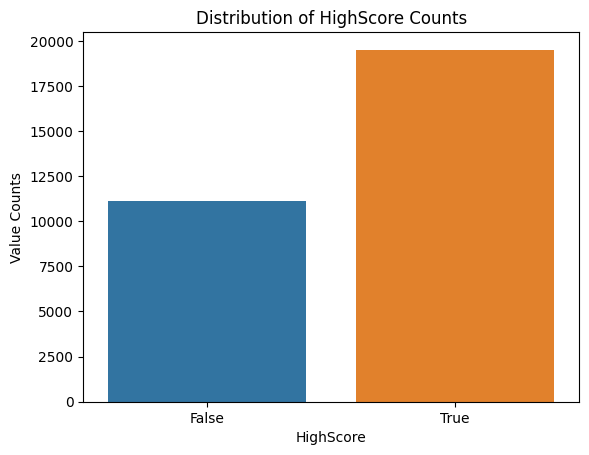

In [21]:
#Print HighScore value counts
print(df['HighScore'].value_counts(normalize=True))
#Print HighScore value counts
print(df['HighScore'].value_counts())

#Plot class distribution
sns.barplot(y = df['HighScore'].value_counts(), x = df['HighScore'].unique())
plt.xlabel('HighScore')
plt.ylabel('Value Counts')
plt.title('Distribution of HighScore Counts')
plt.show()

As we can see, most of recipes have a High Score which is represented by the value 1, 63,7% of the total scores are High, the remaining 36,3 are classified as Low score.

Lets continue analyzing the relationship between the numeric variables creating a correlation matrix and a heat map

                     Calories  CholesterolContent  CarbohydrateContent  \
Calories             1.000000            0.605167             0.551294   
CholesterolContent   0.605167            1.000000             0.020385   
CarbohydrateContent  0.551294            0.020385             1.000000   
SugarContent         0.077182           -0.084554             0.365245   
ProteinContent       0.699145            0.704344             0.159960   
RecipeServings      -0.086248           -0.035220             0.023101   
HighScore           -0.008195           -0.006329            -0.038077   

                     SugarContent  ProteinContent  RecipeServings  HighScore  
Calories                 0.077182        0.699145       -0.086248  -0.008195  
CholesterolContent      -0.084554        0.704344       -0.035220  -0.006329  
CarbohydrateContent      0.365245        0.159960        0.023101  -0.038077  
SugarContent             1.000000       -0.140412        0.102294   0.016435  
ProteinConte

[]

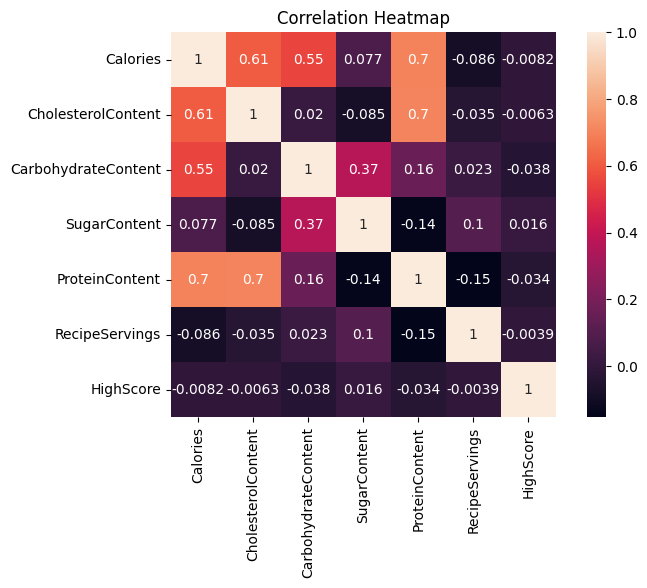

In [22]:
#Create a list with the numeric columns of interest
numeric_cols = ['Calories','CholesterolContent','CarbohydrateContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'HighScore']

# Create the correlation matrix between features
corrmat = df[numeric_cols].corr()

#Print correlation matrix
print(corrmat)

#Create correlation heatmap
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(corrmat, vmax=1, square=True, annot = True)
plt.title('Correlation Heatmap')
plt.plot()

As we can see High Score is not correlated to any of the other numeric features as its correlation values are around 0, we can see that the most correlated variables are Calories, Protein and Carbohydrate Content, as they show values between 0.56 to 0.71 which means that they have a moderate-strong positive relationship.

Let's continue exploring these relationships creating scatter plots between the variables

[]

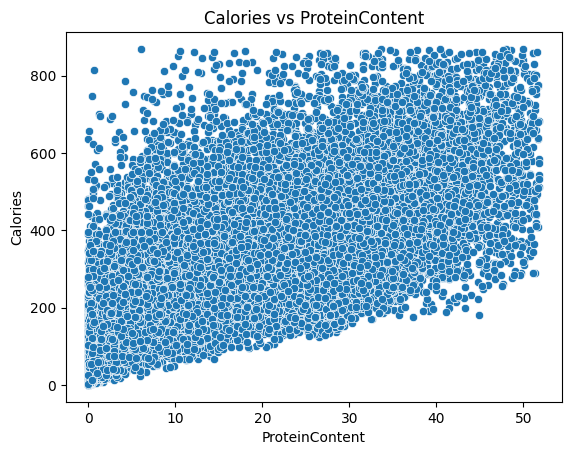

In [23]:
#Plot ProteinContent vs Calories
sns.scatterplot( x = 'ProteinContent', y = 'Calories', data = df)
plt.title('Calories vs ProteinContent')
plt.plot()

[]

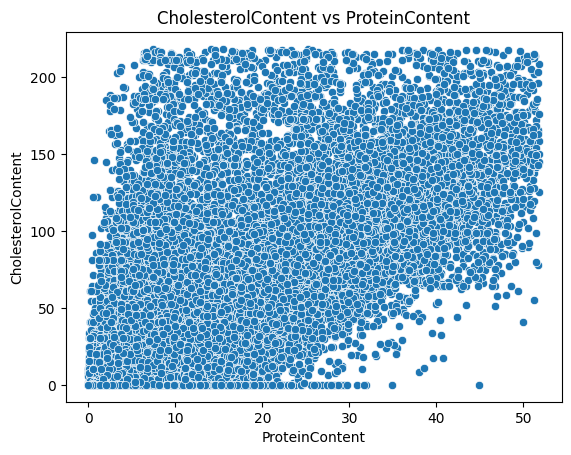

In [24]:
#Plot ProteinContent vs CholesterolContent
sns.scatterplot( x = 'ProteinContent', y = 'CholesterolContent', data = df)
plt.title('CholesterolContent vs ProteinContent')
plt.plot()

Although there is a lot of points  we can see that in general there is a moderate-strong positive relationship between Protein Content and Calories, also between Cholesterol Content and Protein Content.

### Exploratory analysis summary

In order to better understand our data we have conducted an exploratory analysis:

- First we plotted box plots of our numeric variables to check the distribution of values after dropping outliers of the original data and new distributions make sense.

- Second we analyzed the Recipe Category column, by counting how many there are, then taking a look of those which represent more than 1% of the total data and plot the results. We could see that 20 categories account for 67,3 of the total categories being the top 5 general recipes.

- Third we analyzed the distribution of our target variable High Score, and saw that most of values are 1, which means that are positive scored (High Scored is 1, if not value is 0), 1 values accounted for 63,7% of total so we can state that the majority of recipes get a positive score.

- Fourth we analyzed the relationship between all the numeric variables using a correlation matrix and a heat map to represent it, we have seen that High Score has no correlation with the other numeric variables, while others have moderate-strong positive correlation.

- Fifth we plotted the relationships between Protein Content and Calories, Protein Content and Cholesterol to visualize their positive correlation.

## Model Development

Given the provided data and business problem, the case is a supervised learning problem, a classification, as the goal is to use the existing data to create a model that labels new data as High Score = 1 or High Score = 0, a discrete binary target variable. 

Our job is to create a model which can classify recipes into those two categories.

For this classification problem we will create the following models:

- Logistic Regression
- Decision Tree Classifier


Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables. In our case the binary outcome  or target variable is whether the recipe has a High Score (1) or not (0).

Decision Tree Learning is a supervised learning approach used in statistics, data mining and machine learning. In this formalism, a classification or regression decision tree is used as a predictive model to draw conclusions about a set of observations.

Tree models where the target variable can take a discrete set of values are called classification trees


Since we have a binary classification problem we will use accuracy score as the comparing metric or KPI, we will calculate the accuracy score for each binary class 1 and 0.

Accuracy Score measures the percentage of correct labels predicted over total predictions

We will also print the Confusion Matrix:

Confusion matrix goes deeper than classification accuracy by showing the correct and incorrect (i.e. true or false) predictions on each class ( classes in our problem are HighScore = 1 and HighScore = 0). A way to visualize the results. 

Now we have to determine which variables will be used in our model, the target variable is High Score.

We will use the numeric variables Calories, CholesterolContent, CarbohydrateContent, SugarContent, ProteinContent and RecipeServings as features, leaving RecipeCategory due to the high number of unique ones (240).

Our class data (High Score) is unbalanced, we have seen that the distribution is around 64% for 1 values and 36% for 0 values. We will resample our model in order to have a 50-50 distribution

(20000, 10)
False    0.5
True     0.5
Name: HighScore, dtype: float64


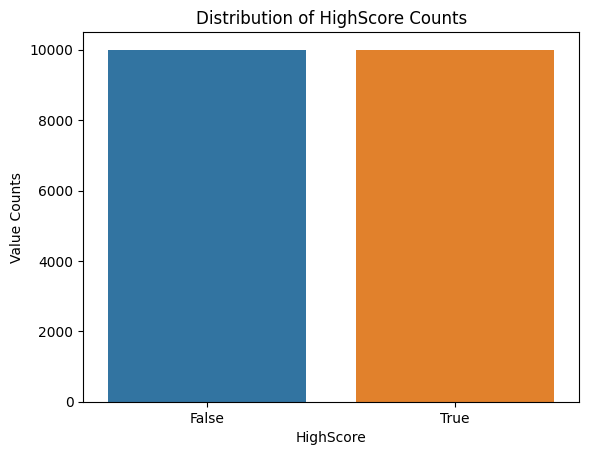

In [25]:
#Random sample our data set
df_sampled = df.sample(frac=1, random_state = 1007)

#Select 10k rows with HighScore = 1
df_1 = df_sampled[df_sampled['HighScore'] == 1].iloc[:10000]

#Select 10k rows with HighScore = 0
df_0 = df_sampled[df_sampled['HighScore'] == 0].iloc[:10000]

#Concatenate dfs
df_model = pd.concat([df_1, df_0], axis = 0)

#Random sample df
df_model = df_model.sample(frac=1, random_state = 1007)

#Print df_model shape, high score value distribution
print(df_model.shape)
print(df_model['HighScore'].value_counts(normalize = True))

#Plot class distribution
sns.barplot(y = df_model['HighScore'].value_counts(), x = df_model['HighScore'].unique())
plt.xlabel('HighScore')
plt.ylabel('Value Counts')
plt.title('Distribution of HighScore Counts')
plt.show()

Now the data for our model has an equally balanced class distribution of 50% for High Score = 1 and 50% for High Score = 0

In [26]:
#Print summary statistics of our features
features_df = df_model.drop(['RecipeId', 'Name', 'RecipeCategory','HighScore'], axis = 1)

print(features_df.describe())

           Calories  CholesterolContent  CarbohydrateContent  SugarContent  \
count  20000.000000        20000.000000         20000.000000   20000.00000   
mean     290.305760           52.642910            25.973970       7.00662   
std      170.364816           53.164155            18.650871       7.01248   
min        0.100000            0.000000             0.000000       0.00000   
25%      161.000000            2.500000            10.700000       2.00000   
50%      264.600000           38.600000            22.900000       4.50000   
75%      393.100000           85.100000            37.400000       9.60000   
max      869.500000          218.500000            87.300000      30.30000   

       ProteinContent  RecipeServings  
count    20000.000000    20000.000000  
mean        14.488415        5.731400  
std         12.699026        2.907624  
min          0.000000        1.000000  
25%          3.900000        4.000000  
50%          9.900000        6.000000  
75%         24.00

Since we have different scales in our numeric variables we will Normalize its values before creating the models, now we create the arrays for the model and split our data into training and testing for model purposes.

In [27]:
#Create X and y variables as np array
y = df_model['HighScore'].values
X = features_df.values

#Instantiate Normalizer
norm = Normalizer()

#Fit transform X data
X = norm.fit_transform(X)

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1007, stratify = y)

Next we create the two models, tune its hyperparameters and compute its Accuracy Score 

In [28]:
#Instantiate a Logistic Regression model
lr = LogisticRegression(random_state =1007)

#Instantiate Kfold
kf = KFold (n_splits =10, shuffle = True, random_state = 1007)

#Parameters
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty': ['none','l1','l2','elasticnet'],
              'C': [100, 10, 1.0, 0.1, 0.01]}
#Instantiate GridSearchCV
grid = GridSearchCV(lr, param_grid, cv = kf, n_jobs = -1, scoring = 'accuracy')

#Fit model
grid.fit(X_train, y_train)

#Print results
print(grid.best_params_, grid.best_score_)

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'} 0.5375714285714286


Next we create the Logistic Regression with that parameters

In [29]:
#Instantiate a Logistic Regression model
lr = LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs', random_state =1007)

#Fit model
lr.fit(X_train, y_train)

#Predict
lr_y_pred = lr.predict(X_test)

#Accuracy Score
lr_accuracy = accuracy_score(y_test, lr_y_pred) 

#Print results
print("The Logistic Regression accuracy score  is {:f}".format(lr_accuracy))

The Logistic Regression accuracy score  is 0.525333


In [30]:
#Instantiate a Decision Tree Classifier model
dt = DecisionTreeClassifier(random_state =1007)

#Instantiate Kfold
kf = KFold (n_splits =10, shuffle = True, random_state = 1007)

#Parameters
param_grid = {'max_depth': [2,5,10,20], 'min_samples_leaf':[0.12,0.4,0.5,0.7], 'criterion':['gini',  'entropy']}

#Instantiate GridSearchCV
grid = GridSearchCV(dt, param_grid, cv = kf, n_jobs = -1, scoring = 'accuracy')

#Fit model
grid.fit(X_train, y_train)

#Print results
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 0.12} 0.5265714285714285


Next we create the Decision Tree Classifier with that parameters

In [31]:
#Instantiate a Decision Tree Classifier model
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 0.12, random_state =1007)

#Fit model
dt.fit(X_train, y_train)

#Predict
dt_y_pred = dt.predict(X_test)

#Accuracy Score
dt_accuracy = accuracy_score(y_test, dt_y_pred) 

#Print results
print("The Decision Tree Classifier accuracy score  is {:f}".format(dt_accuracy))

The Decision Tree Classifier accuracy score  is 0.535667


## Model Evaluation

As we can see we the model that shows better overall performance is the Decision Tree Classifier with a 53.6% of correct predictions, still its slightly better than the Logistic Regression which had 52.5% of correct predictions. Both models performs poorly when predicting the HighScore result. 

Both models obtained a poor Accuracy Score, the scores of 53.6% for the Decision Tree Classifier and the 52.5% of the Logistic Regression are just slightly better than a random guessing, as our HighScore values are distributed equally, 50% for each class (High Scored = 1, Low Scored = 0).

As the goal is to be able to correctly classify all new recipes, the Decision Tree Classifier is the best performing model, it can correctly predict the 53.6% of new recipes score.

In order to evaluate the model performance against the Business Success Criteria we will analyze our results using the confusion matrix, and then calculating the accuracy scores for each class.

Now we create a the confusion Matrix for each model, and calculate the accuracy scores for each class

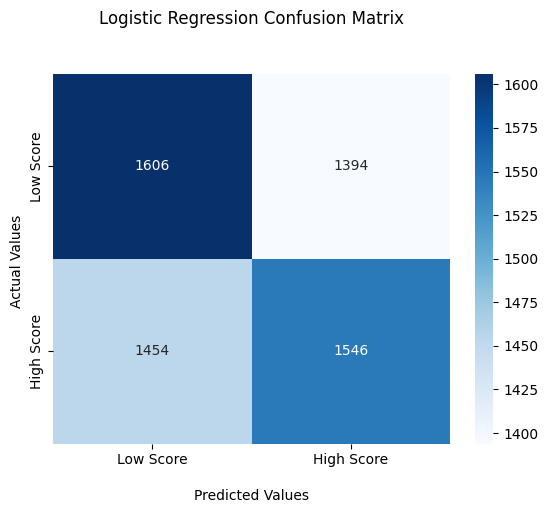

In [32]:
#Create Confusion Matrix
cf_matrix = confusion_matrix(y_test, lr_y_pred)

#Plot Confusion Matrix
ax = sns.heatmap(cf_matrix, fmt='g', annot=True, cmap='Blues')

ax.set_title('Logistic Regression Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low Score','High Score'])
ax.yaxis.set_ticklabels(['Low Score','High Score'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [33]:
#Overall Accuracy Score
lr_accuracy = accuracy_score(y_test, lr_y_pred)

#Accuracy score class 0 (Low Scoring)
lr_accuracy_0 = 1606 / 3000

#Accuracy score class 1 (High Scoring)
lr_accuracy_1 = 1546 / 3000

#Print results
print("The Logistic Regression correctly predicts {0:.2%} of Total Recipes".format(lr_accuracy))
print("The Logistic Regression correctly predicts {0:.2%} of Low Score Recipies".format(lr_accuracy_0))
print("The Logistic Regression predicts {0:.2%} of High Score Recipies".format(lr_accuracy_1))

The Logistic Regression correctly predicts 52.53% of Total Recipes
The Logistic Regression correctly predicts 53.53% of Low Score Recipies
The Logistic Regression predicts 51.53% of High Score Recipies


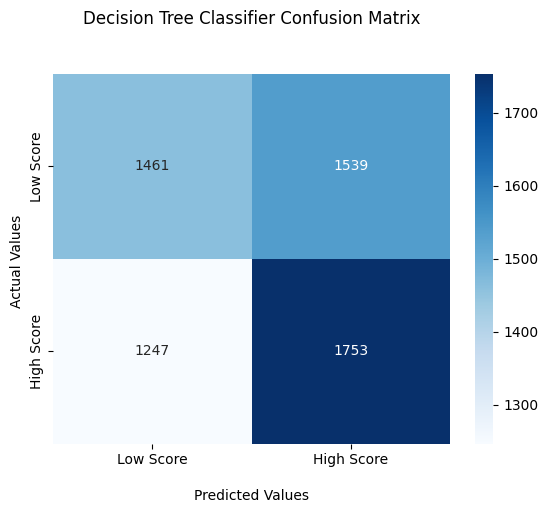

In [34]:
#Create Confusion Matrix
cf_matrix = confusion_matrix(y_test, dt_y_pred)

#Plot Confusion Matrix
ax = sns.heatmap(cf_matrix, fmt='g', annot=True, cmap='Blues')

ax.set_title('Decision Tree Classifier Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Low Score','High Score'])
ax.yaxis.set_ticklabels(['Low Score','High Score'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [35]:
#Overall Accuracy Score
dt_accuracy = accuracy_score(y_test, dt_y_pred)

#Accuracy score class 0 (Low Scoring)
dt_accuracy_0 = 1461 / 3000

#Accuracy score class 1 (High Scoring)
dt_accuracy_1 = 1753 / 3000

#Print results
print("The Decision Tree Classifier correctly predicts {0:.2%} of Total Recipes".format(dt_accuracy))
print("The Decision Tree Classifier correctly predicts {0:.2%} of Low Score Recipies".format(dt_accuracy_0))
print("The Decision Tree Classifier predicts {0:.2%} of High Score Recipies".format(dt_accuracy_1))

The Decision Tree Classifier correctly predicts 53.57% of Total Recipes
The Decision Tree Classifier correctly predicts 48.70% of Low Score Recipies
The Decision Tree Classifier predicts 58.43% of High Score Recipies


In [36]:
#Create column names
column_names = ['Model', 'Acuraccy Score', 'High Score Accuracy', 'Low Score Accuracy']

#Create data for df
data = [['Logistic Regression', "{:.2%}".format(lr_accuracy), "{:.2%}".format(lr_accuracy_1), "{:.2%}".format(lr_accuracy_0)],
        ['Decision Tree Classifier', "{:.2%}".format(dt_accuracy), "{:.2%}".format(dt_accuracy_1), "{:.2%}".format(dt_accuracy_0)]]

#Create df
df_final_results = pd.DataFrame(data, columns = column_names)

#Set Model as Index
df_final_results = df_final_results.set_index('Model')

#Print df
df_final_results

,Acuraccy Score,High Score Accuracy,Low Score Accuracy
Model,,,
Logistic Regression,52.53%,51.53%,53.53%
Decision Tree Classifier,53.57%,58.43%,48.70%


## Comparison to the Business Success Criteria

### Success Criteria

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how your approach compares to this.

Our best model for predicting the low scoring recipes is Logistic Regression which correctly categorize 53.53% of all low scoring recipes, so it doesn't beat the current company system for categorizing the recipes.

The Decision Tree model performs better predicting the class 1 with an accuracy of 58.43%.

## Final summary

The goal of this project was to create a model which can predict if the new recipes of the web will have a High Score or a Low Score.

The Decision Tree Classifier model which had the better overall accuracy score can correctly predict 53,57% of the recipes score, still failed to achieve the actual 75% benchmark that the company has for predicting low scoring recipes, also the performance of the model is slightly better than a random guess.

The Logistic Regression model was better predicting the low score recipes with a 53.53% score versus the 48.70% of the Decision Tree Classifier.
The Decision Tree Classifier was better predicting the high score recipes, with a 58.43% vs the 51.53% of the Logistic Regression Model.


Business recommendations:

- Understand how the company is obtaining the 75% benchmark, which data and process is using to achieve this, this information could lead us to create a better performing model.  

- Try different classification algorithms using the same data in order to improve performance such as:

    - Support Vector Machine
    - Naive Bayes
    - K Nearest Neighbors
    - Neural Networks
    - Gradient Boosting

   
   
- Try different features for the model, using only the categories, reducing the numeric features, or combining numeric and categorical features for example.

- Reduce the number of categories in order to group better the data.

- Use unsupervised learning models in order to try find patterns in the data that helps predicting the scores 
